# Bear Classifier

Grizzly, Black, or Teddy Bear?

In [1]:
from fastai.data.all import *
from fastai.vision.all import *
from fastcore.all import *

## Image Download

In [4]:
from duckduckgo_search import DDGS

def search_images(search_term, max_images = 100):
    return L(DDGS().images(search_term, max_results = max_images)).itemgot('image')

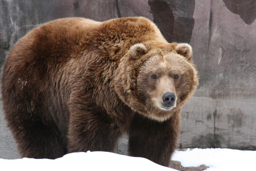

In [8]:
from fastdownload import download_url

image_urls = search_images('grizzly', max_images = 1)

destination = 'bears/grizzly.jpg'
download_url(image_urls[0], destination)

image = Image.open(destination)
image.to_thumb(256, 256)

In [2]:
from pathlib import Path
data_set_path = Path('bears')
bear_types = 'grizzly', 'black', 'teddy'

In [12]:
from fastai.vision.utils import download_images

for bear_type in bear_types:
    destination = data_set_path/bear_type
    destination.mkdir(exist_ok = True)
    search_results = search_images(f'{bear_type} bear', max_images = 100)
    download_images(destination, urls = search_results)

## Verify Images

In [13]:
from fastai.vision.utils import get_image_files, verify_images

failed_images = verify_images(get_image_files(data_set_path))
failed_images.map(Path.unlink)
len(failed_images)

12

## Data Sets

In [3]:
bears_data = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
    get_y = parent_label,
    item_tfms = Resize(128),
    batch_tfms = aug_transforms(mult = 2)
).dataloaders(data_set_path)

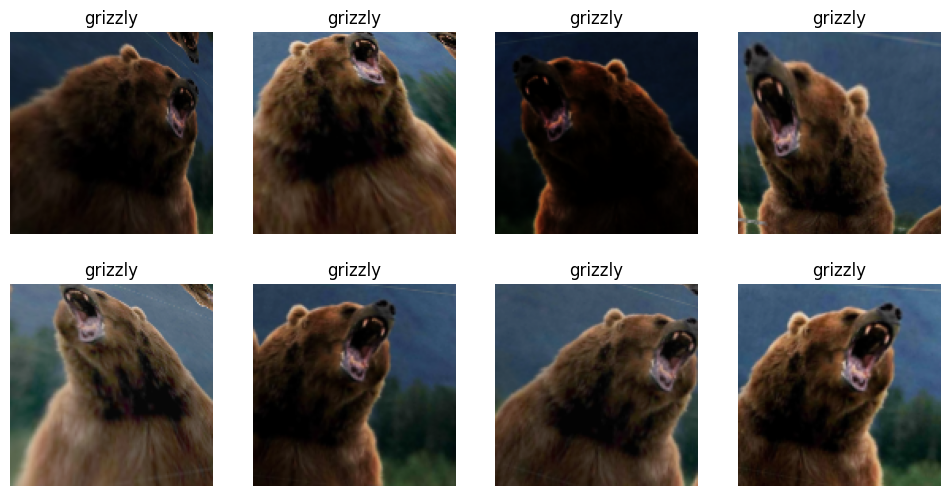

In [23]:
bears_data.train.show_batch(max_n = 8, nrows = 2, unique = True)

## Train Model

In [4]:
model = vision_learner(bears_data, resnet18, metrics = error_rate)
model.fine_tune(4)

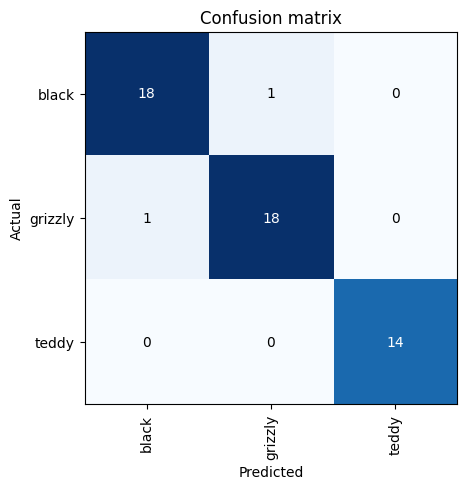

In [5]:
interpretation = ClassificationInterpretation.from_learner(model)
interpretation.plot_confusion_matrix()

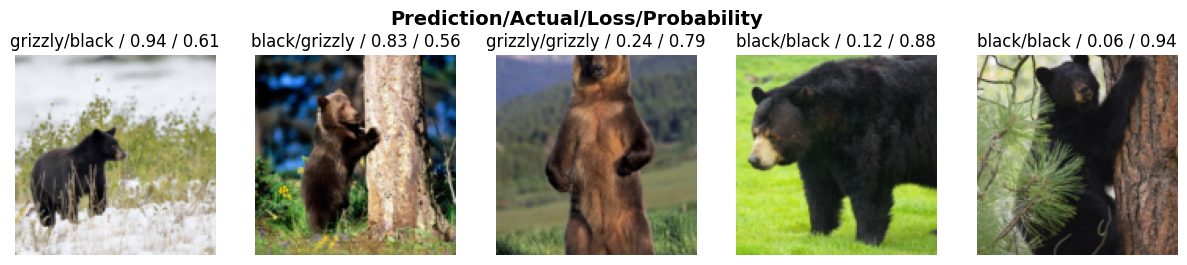

In [6]:
interpretation.plot_top_losses(5, nrows = 1)

## Clean Data Set

The model should be re-trained after this step.

It's just helpful to view problematic images and their predictions with a base model.

In [54]:
for image_file in get_image_files(data_set_path):
    image = Image.open(image_file)
    if image.mode != 'RGB':
        # These image files will fail to be opened with the image cleaner by default.
        print(image_file)
        image = image.convert('RGB')
        image.save(image_file)
    if image_file.suffix == '.png':
        print(image_file)
        image.save(image_file, format = 'JPEG')

In [9]:
from fastai.vision.widgets import ImageClassifierCleaner

cleaner = ImageClassifierCleaner(model)
cleaner

## Export Model

In [10]:
model.export()